# Convolutional Neural Networks (CNNs)

Convolutional Neural Networks are a class of deep learning models specialized for processing **grid-like data** (especially images). CNNs are widely used in computer vision tasks like classification, segmentation, and object detection.

---

## Components of a CNN

1. **Convolution Layer**
2. **Activation Function (usually ReLU)**
3. **Pooling Layer (e.g., Max Pooling)**
4. **Fully Connected (Dense) Layer**
5. **Softmax (for classification tasks)**

---

## 1. Convolution Operation

Let:
- Input image $I \in \mathbb{R}^{H \times W}$
- Kernel (filter) $K \in \mathbb{R}^{k_H \times k_W}$

Then the **discrete 2D convolution** (without padding) is:

$$
S(i, j) = (I * K)(i, j) = \sum_{m=0}^{k_H - 1} \sum_{n=0}^{k_W - 1} I(i + m, j + n) \cdot K(m, n)
$$

For **stride $s$** and **padding $p$**, the output size becomes:

$$
H_{out} = \left\lfloor \frac{H + 2p - k_H}{s} \right\rfloor + 1, \quad
W_{out} = \left\lfloor \frac{W + 2p - k_W}{s} \right\rfloor + 1
$$

---

## 2. Activation Function

The most common is **ReLU**:

$$
f(x) = \max(0, x)
$$

Other common activations:
- Sigmoid: $f(x) = \frac{1}{1 + e^{-x}}$
- Tanh: $f(x) = \tanh(x)$

---

## 3. Pooling Layer

Used to **downsample** the feature maps and reduce computation.

### Max Pooling (window size $k \times k$):

$$
P(i, j) = \max_{m=0}^{k-1} \max_{n=0}^{k-1} A(i + m, j + n)
$$

Output size with stride $s$:

$$
H_{out} = \left\lfloor \frac{H - k}{s} \right\rfloor + 1, \quad
W_{out} = \left\lfloor \frac{W - k}{s} \right\rfloor + 1
$$

---

## 4. Fully Connected Layer

Let:
- Input vector $x \in \mathbb{R}^n$
- Weights $W \in \mathbb{R}^{m \times n}$
- Bias $b \in \mathbb{R}^m$

Then output:

$$
y = W x + b
$$

---

## 5. Softmax for Classification

Softmax turns logits into probabilities:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$

Cross-entropy loss (for label $y$ and prediction $\hat{y}$):

$$
L = - \sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

---

# CNN Implementation in NumPy

Below is a minimal CNN-like computation using NumPy.

```python

def conv2d(X, K, stride=1, padding=0):
    X_padded = np.pad(X, ((padding, padding), (padding, padding)), mode='constant')
    kH, kW = K.shape
    H_out = (X_padded.shape[0] - kH) // stride + 1
    W_out = (X_padded.shape[1] - kW) // stride + 1
    out = np.zeros((H_out, W_out))
    for i in range(0, H_out):
        for j in range(0, W_out):
            region = X_padded[i*stride:i*stride+kH, j*stride:j*stride+kW]
            out[i, j] = np.sum(region * K)
    return out

def maxpool2d(X, size=2, stride=2):
    H, W = X.shape
    H_out = (H - size) // stride + 1
    W_out = (W - size) // stride + 1
    out = np.zeros((H_out, W_out))
    for i in range(H_out):
        for j in range(W_out):
            region = X[i*stride:i*stride+size, j*stride:j*stride+size]
            out[i, j] = np.max(region)
    return out

# CNN in Action

In this notebook a simple convolutional neural network will be trained on MNIST dataset

## Import libraries

In [1]:
import os
from tqdm import trange

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import matplotlib.pyplot as plt

### Load the dataset

In [ ]:
training_data = datasets.MNIST(
    root='../../../datasets',
    train=True,
    download=False, # True if is not downloaded
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.MNIST(
    root='../../../datasets',
    train=False,
    download=False, # True if is not downloaded
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

## Move dataset to pytorch dataloaders (for training)

In [3]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [4]:
def display_random_image(data: DataLoader):
    random_number = np.random.randint(1, 5)
    for i in range(random_number):
        train_features, train_labels = next(iter(data))

    image_features, image_label = train_features[random_number], train_labels[random_number]

    plt.imshow(image_features.squeeze(), cmap='gray')
    plt.title(torch.argmax(image_label).item())

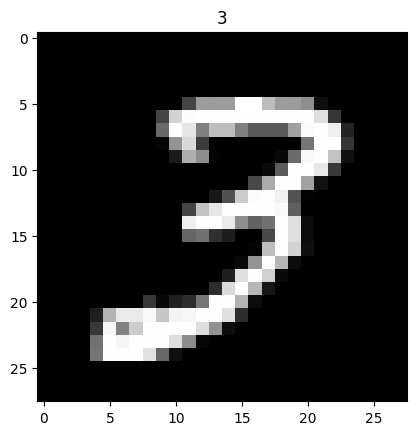

In [5]:
display_random_image(train_dataloader)

set device ( if gpu is available)

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## PyTorch `SimpleCNN` Class

This is a simple Convolutional Neural Network (CNN) implemented using PyTorch's `nn.Module`. It is designed for grayscale images with **1 channel** and produces logits for **10 output classes** (e.g., MNIST digits).

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.simple_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(36, 10)
        )

    def forward(self, x):
        logits = self.simple_stack(x)
        return logits

Prepare the model

In [8]:
model = SimpleCNN()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train epoch function
A function that trains the model by one epoch

In [ ]:
def train_epoch(dataloader: DataLoader, model: SimpleCNN, loss_fn: nn.CrossEntropyLoss, optimizer: torch.optim):
    model.to(device)
    model.train()
    epoch_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # Move tenors to device
        pred = model(X) # predict
        loss = loss_fn(pred, y) # calculate loss

        loss.backward() # gradient descend
        optimizer.step() # update weights
        optimizer.zero_grad()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)

    return avg_loss

### Test epoch function
A function that evaluates the model by one epoch

In [10]:
def test_epoch(model: SimpleCNN, dataloader: DataLoader, loss_fn: nn.CrossEntropyLoss):
    model.eval()

    epoch_accuracy = 0
    epoch_loss = 0
    total_samples = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)

            pred = logits.argmax(dim=1)
            labels = y.argmax(dim=1)

            epoch_loss += loss_fn(logits, y).item()
            
            correct_preds = (pred == labels).sum().item()
            epoch_accuracy += correct_preds
            total_samples += labels.size(0)

    epoch_accuracy = (epoch_accuracy / total_samples) * 100
    epoch_loss /= total_samples

    return epoch_accuracy, epoch_loss

## General train function

In [11]:
def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epoches):
    train_losses = np.empty(epoches)
    test_losses = np.empty(epoches)
    test_accs = np.empty(epoches)

    for epoch in (pbar := trange(epoches)):
        train_loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        accuracy, test_loss = test_epoch(model, test_dataloader, loss_fn)

        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        test_accs[epoch] = accuracy

    print(f"Finished with accuracy of {accuracy}% and loss equal to {test_loss}")

    return train_losses, test_losses, test_accs

### Train the model

In [12]:
train_losses, test_losses, test_accuracies = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, 10)

100%|██████████| 10/10 [02:10<00:00, 13.08s/it]

Finished with accuracy of 95.09% and loss equal to 0.0022321065662428735


# Results for 10 epochs

In [13]:
def predict(test_dataloader, model):
    random_number = np.random.randint(1, 6)

    image_features, image_labels = None, None
    for i in range(random_number):
        image_features, image_labels = next(iter(test_dataloader))

    pred = model(image_features.to(device))
    print(f"Predicted -> {torch.argmax(pred[random_number])} and the real is {torch.argmax(image_labels[random_number])}")

In [24]:
predict(test_dataloader, model)

Predicted -> 9 and the real is 9


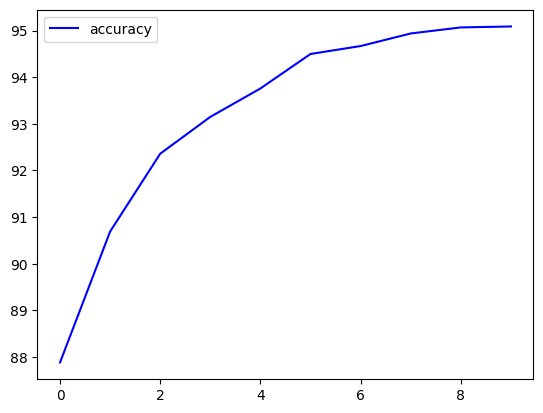

In [15]:
plt.plot(test_accuracies, c='blue', label='accuracy')
plt.legend()
plt.show()

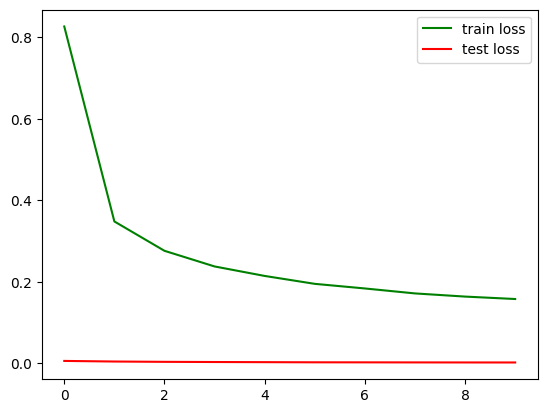

In [18]:
plt.plot(train_losses, c='green', label='train loss')
plt.plot(test_losses, c='red', label='test loss')
plt.legend()
plt.show()
